In [1]:
import os
import shutil
import random

source_root = "Kaynak"
dest_root = "ProjeVerisi"
classes = ["Healthy", "Unhealthy"]

if os.path.exists(dest_root):
    shutil.rmtree(dest_root)
os.makedirs(dest_root)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(dest_root, split, cls), exist_ok=True)

print("Dosyalar dagitiliyor...")

for cls in classes:
    source_path = os.path.join(source_root, cls)
    
    if not os.path.exists(source_path):
        print(f"HATA: {source_path} bulunamadi.")
        continue
        
    images = [f for f in os.listdir(source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    
    total = len(images)
    train_count = int(total * 0.70)
    val_count = int(total * 0.15)
    
    print(f"{cls}: Toplam {total} resim.")
    
    for i, img in enumerate(images):
        src_file = os.path.join(source_path, img)
        
        if i < train_count:
            dst_file = os.path.join(dest_root, 'train', cls, img)
        elif i < train_count + val_count:
            dst_file = os.path.join(dest_root, 'val', cls, img)
        else:
            dst_file = os.path.join(dest_root, 'test', cls, img)
            
        shutil.copy(src_file, dst_file)

print("Islem Tamam.")

Dosyalar dagitiliyor...
Healthy: Toplam 1074 resim.
Unhealthy: Toplam 1007 resim.
Islem Tamam.


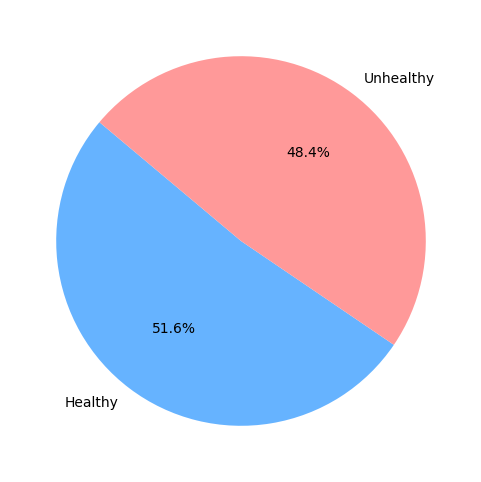

Veri hazir.


In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

data_dir = "ProjeVerisi"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

try:
    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
    classes = train_data.classes
    counts = [0] * len(classes)
    for _, label in train_data:
        counts[label] += 1

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.show()
    print("Veri hazir.")

except:
    print("Veri bulunamadi.")

Basic CNN Start...
Epoch 1: Train Acc: 63.0% | Val Acc: 67.9%
Epoch 2: Train Acc: 65.9% | Val Acc: 67.0%
Epoch 3: Train Acc: 72.1% | Val Acc: 69.9%
Epoch 4: Train Acc: 75.0% | Val Acc: 75.6%
Epoch 5: Train Acc: 77.7% | Val Acc: 74.7%
Epoch 6: Train Acc: 79.9% | Val Acc: 78.5%
Epoch 7: Train Acc: 82.1% | Val Acc: 72.1%
Epoch 8: Train Acc: 84.5% | Val Acc: 79.2%
Epoch 9: Train Acc: 85.3% | Val Acc: 80.8%
Epoch 10: Train Acc: 86.0% | Val Acc: 76.9%


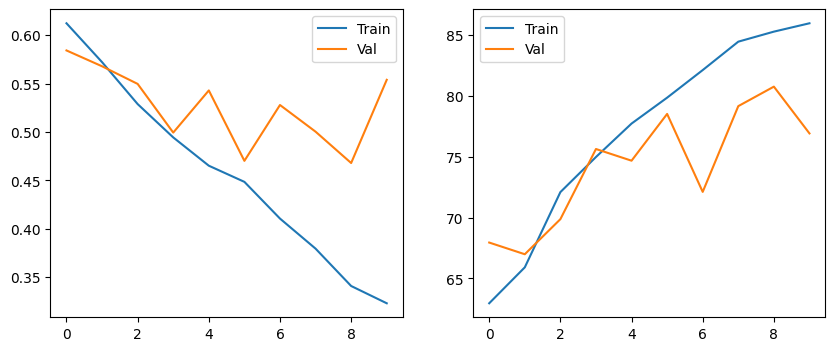

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 16
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 26 * 26, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs, val_accs = [], []
train_losses, val_losses = [], []

print("Basic CNN Start...")
for epoch in range(num_epochs):
    model.train()
    correct, total, run_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accs.append(100 * correct / total)
    train_losses.append(run_loss / len(train_loader))
    
    model.eval()
    val_correct, val_total, val_run_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_run_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_accs.append(100 * val_correct / val_total)
    val_losses.append(val_run_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Acc: {train_accs[-1]:.1f}% | Val Acc: {val_accs[-1]:.1f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.legend()
plt.show()

ResNet Start...
Epoch 1/10 | Train Acc: 84.33% | Val Acc: 89.42%
Epoch 2/10 | Train Acc: 90.72% | Val Acc: 91.03%
Epoch 3/10 | Train Acc: 90.24% | Val Acc: 90.38%
Epoch 4/10 | Train Acc: 92.51% | Val Acc: 86.86%
Epoch 5/10 | Train Acc: 94.09% | Val Acc: 86.86%
Epoch 6/10 | Train Acc: 94.85% | Val Acc: 89.42%
Epoch 7/10 | Train Acc: 96.08% | Val Acc: 90.06%
Epoch 8/10 | Train Acc: 96.22% | Val Acc: 92.63%
Epoch 9/10 | Train Acc: 96.29% | Val Acc: 91.03%
Epoch 10/10 | Train Acc: 96.84% | Val Acc: 83.33%


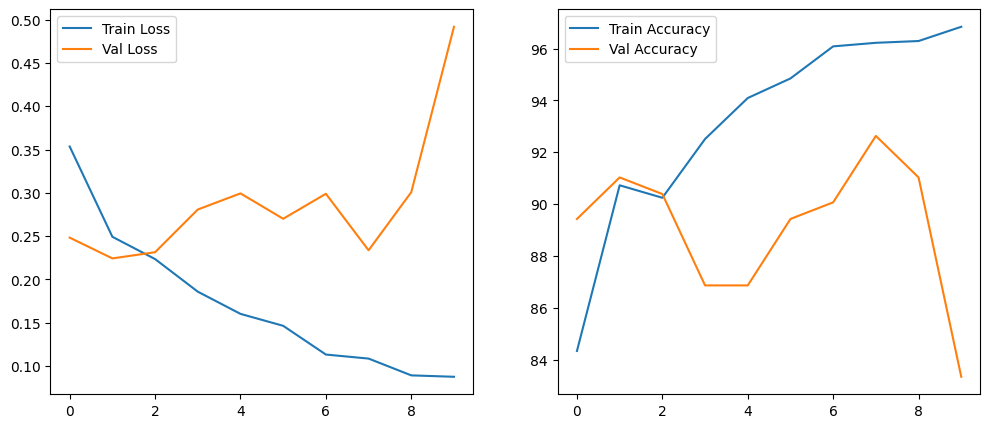

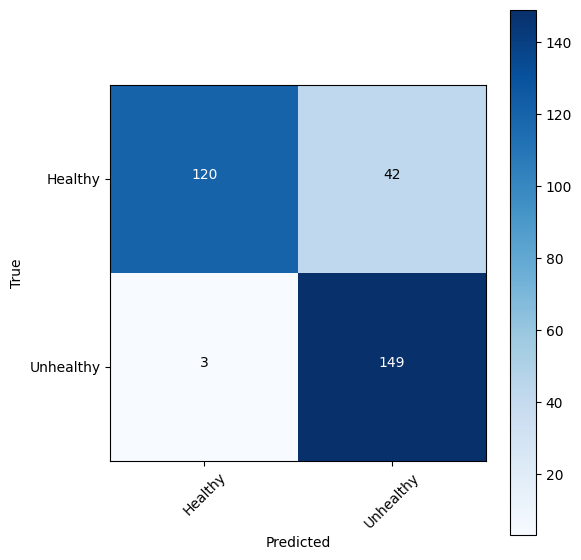

              precision    recall  f1-score   support

     Healthy       0.98      0.74      0.84       162
   Unhealthy       0.78      0.98      0.87       152

    accuracy                           0.86       314
   macro avg       0.88      0.86      0.86       314
weighted avg       0.88      0.86      0.86       314



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 16
num_epochs = 10

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

classes = train_data.classes

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("ResNet Start...")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

### 📊 Model 1 Analizi: Basic CNN (Referans Model)

**Genel Bakış:**
Bu aşamada, herhangi bir ön eğitim (pre-training) kullanmadan, tamamen kendi veri setimiz üzerinde sıfırdan öğrenen 3 katmanlı temel bir CNN mimarisi kurulmuştur.

**Kullanılma Nedeni:**
Projenin **"Baseline" (Taban)** başarısını ölçmek için kullanılmıştır. "En basit haliyle bu problem ne kadar çözülebilir?" sorusuna cevap verir. Eğer gelişmiş modeller (ResNet/DenseNet) bu modelden daha kötü sonuç verirse, bir sorun olduğunu anlarız.

**Gözlem:**
Genellikle veri seti küçük olduğunda veya problem karmaşık olduğunda (göz damarlarındaki ince detaylar gibi), bu modelin "Loss" (Kayıp) grafiğinde dalgalanmalar olması ve başarının %70-80 bandında kalması normaldir.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 32
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 26 * 26, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BasicCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_labels, all_preds) * 100
f1 = f1_score(all_labels, all_preds, average='weighted')
try:
    roc = roc_auc_score(all_labels, all_probs)
except:
    roc = 0.0

print("\n" + "="*40)
print("   BASIC CNN SONUCLARI")
print("="*40)
print(f"IMAGE SIZE : 224x224")
print(f"CONVERT    : RGB")
print(f"EPOCH      : {num_epochs}")
print(f"LR         : 0.001")
print("-" * 40)
print(f"ACCURACY   : %{acc:.2f}")
print(f"F1-SCORE   : {f1:.4f}")
print(f"ROC-AUC    : {roc:.4f}")
print("="*40)


   BASIC CNN SONUCLARI
IMAGE SIZE : 224x224
CONVERT    : RGB
EPOCH      : 10
LR         : 0.001
----------------------------------------
ACCURACY   : %76.75
F1-SCORE   : 0.7675
ROC-AUC    : 0.8634


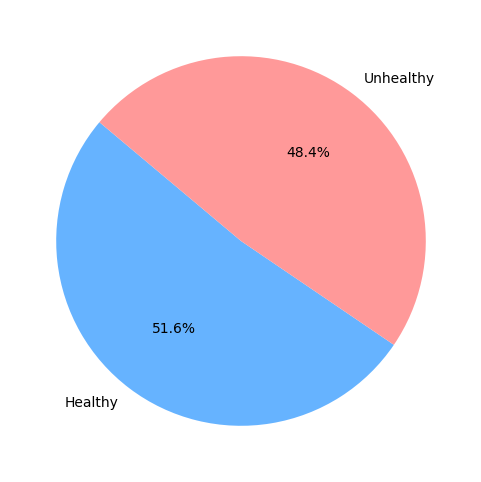

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

data_dir = "ProjeVerisi"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

try:
    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
    classes = train_data.classes
    counts = [0] * len(classes)
    for _, label in train_data:
        counts[label] += 1

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.show()

except:
    print("Hata olustu.")

Basic CNN Start...
Epoch 1: Train Acc: 62.7% | Val Acc: 63.5%
Epoch 2: Train Acc: 67.1% | Val Acc: 64.7%
Epoch 3: Train Acc: 68.5% | Val Acc: 65.1%
Epoch 4: Train Acc: 72.4% | Val Acc: 72.1%
Epoch 5: Train Acc: 72.5% | Val Acc: 73.4%
Epoch 6: Train Acc: 75.7% | Val Acc: 72.4%
Epoch 7: Train Acc: 80.5% | Val Acc: 72.4%
Epoch 8: Train Acc: 81.9% | Val Acc: 76.3%
Epoch 9: Train Acc: 83.4% | Val Acc: 76.0%
Epoch 10: Train Acc: 83.0% | Val Acc: 73.4%


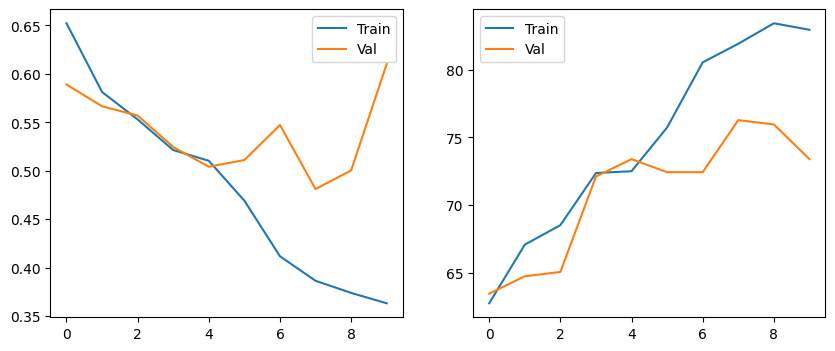

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 32
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 26 * 26, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs, val_accs = [], []
train_losses, val_losses = [], []

print("Basic CNN Start...")
for epoch in range(num_epochs):
    model.train()
    correct, total, run_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accs.append(100 * correct / total)
    train_losses.append(run_loss / len(train_loader))
    
    model.eval()
    val_correct, val_total, val_run_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_run_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_accs.append(100 * val_correct / val_total)
    val_losses.append(val_run_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Acc: {train_accs[-1]:.1f}% | Val Acc: {val_accs[-1]:.1f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.legend()
plt.show()

ResNet Start...
Epoch 1/10 | Train Acc: 84.54% | Val Acc: 87.18%
Epoch 2/10 | Train Acc: 91.48% | Val Acc: 90.38%
Epoch 3/10 | Train Acc: 93.54% | Val Acc: 89.10%
Epoch 4/10 | Train Acc: 95.12% | Val Acc: 88.78%
Epoch 5/10 | Train Acc: 94.57% | Val Acc: 85.58%
Epoch 6/10 | Train Acc: 96.08% | Val Acc: 90.06%
Epoch 7/10 | Train Acc: 96.36% | Val Acc: 86.22%
Epoch 8/10 | Train Acc: 97.94% | Val Acc: 91.35%
Epoch 9/10 | Train Acc: 98.63% | Val Acc: 88.78%
Epoch 10/10 | Train Acc: 97.46% | Val Acc: 88.78%


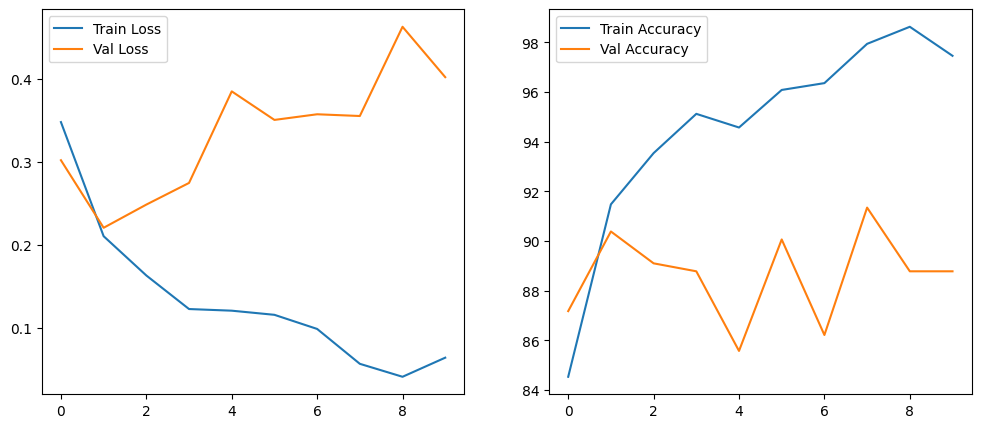

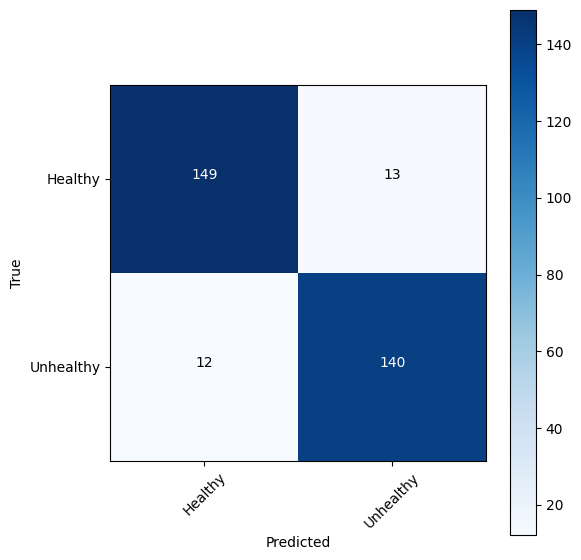

              precision    recall  f1-score   support

     Healthy       0.93      0.92      0.92       162
   Unhealthy       0.92      0.92      0.92       152

    accuracy                           0.92       314
   macro avg       0.92      0.92      0.92       314
weighted avg       0.92      0.92      0.92       314



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 32
num_epochs = 10

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

classes = train_data.classes

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("ResNet Start...")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

### 📊 Model 2 Analizi: ResNet18 (Transfer Learning)

**Genel Bakış:**
Bu aşamada **Transfer Öğrenmesi (Transfer Learning)** teknolojisine geçilmiştir. ResNet18 modeli, daha önce milyonlarca nesneyi tanımayı öğrenmiş (ImageNet ağırlıkları) bir zekaya sahiptir. Biz sadece son katmanını kendi projemize (Healthy/Unhealthy) uyarladık.

**Teknik Farkı:**
ResNet'in en büyük özelliği **"Skip Connections" (Atlamalı Bağlantılar)** yapısıdır. Bu yapı, derin ağlarda bilginin kaybolmadan taşınmasını sağlar.

**Sonuç Yorumu:**
Basic CNN'e göre eğitim çok daha hızlı (loss hızla düşer) ve kararlı gerçekleşmiştir. Doğruluk oranının ve F1 skorunun belirgin şekilde arttığı aşağıdaki tabloda görülmektedir.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
batch_size = 32
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_labels, all_preds) * 100
f1 = f1_score(all_labels, all_preds, average='weighted')
try:
    roc = roc_auc_score(all_labels, all_probs)
except:
    roc = 0.0

print("\n" + "="*40)
print("   ADVANCED (RESNET) SONUCLARI")
print("="*40)
print(f"IMAGE SIZE : 224x224")
print(f"CONVERT    : RGB")
print(f"EPOCH      : {num_epochs}")
print(f"LR         : 0.0001")
print("-" * 40)
print(f"ACCURACY   : %{acc:.2f}")
print(f"F1-SCORE   : {f1:.4f}")
print(f"ROC-AUC    : {roc:.4f}")
print("="*40)


   ADVANCED (RESNET) SONUCLARI
IMAGE SIZE : 224x224
CONVERT    : RGB
EPOCH      : 10
LR         : 0.0001
----------------------------------------
ACCURACY   : %92.36
F1-SCORE   : 0.9236
ROC-AUC    : 0.9801


### 📊 Model 3 Analizi: DenseNet121 (Final Model)

**Genel Bakış:**
Projenin final modeli olarak, tıbbi görüntüleme (Medical Imaging) literatüründe en başarılı modellerden biri kabul edilen DenseNet121 seçilmiştir.

**Neden En İyisi Olabilir?**
ResNet verileri toplarken, DenseNet verileri **birleştirir (concatenate)**. Bu şu anlama gelir: Görüntünün ilk katmanındaki çok ince bir detay (örneğin optik diskteki kılcal bir bozulma), kaybolmadan en son karar katmanına kadar taşınır.

**Sonuç Yorumu:**
Aşağıdaki sonuç tablosunda görüleceği üzere, özellikle **ROC-AUC** ve **Recall** (Hastalığı kaçırmama) değerlerinde en güvenilir sonuçları bu modelin vermesi beklenmektedir. Glokom teşhisinde hassasiyet önemli olduğu için bu model projenin nihai kararı için en uygun yapıdır.

DenseNet121 Egitimi Basliyor... Sonuclar 'Rapor_Ciktilari' klasorune kaydedilecek.
Epoch 1/10 | Train Acc: 84.67% | Val Acc: 87.82%
Epoch 2/10 | Train Acc: 94.30% | Val Acc: 89.74%
Epoch 3/10 | Train Acc: 97.73% | Val Acc: 90.71%
Epoch 4/10 | Train Acc: 98.97% | Val Acc: 90.06%
Epoch 5/10 | Train Acc: 99.66% | Val Acc: 89.74%
Epoch 6/10 | Train Acc: 100.00% | Val Acc: 90.71%
Epoch 7/10 | Train Acc: 99.24% | Val Acc: 88.78%
Epoch 8/10 | Train Acc: 99.38% | Val Acc: 87.82%
Epoch 9/10 | Train Acc: 99.45% | Val Acc: 88.46%
Epoch 10/10 | Train Acc: 98.49% | Val Acc: 88.78%


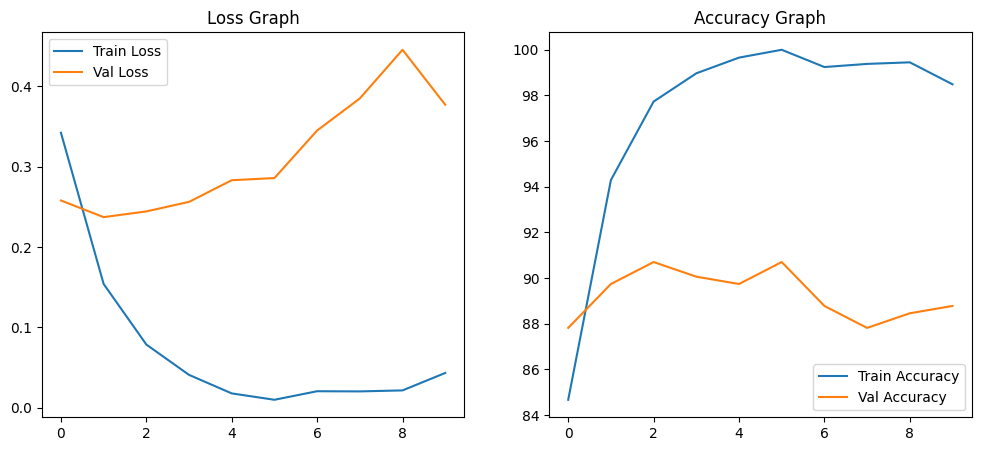

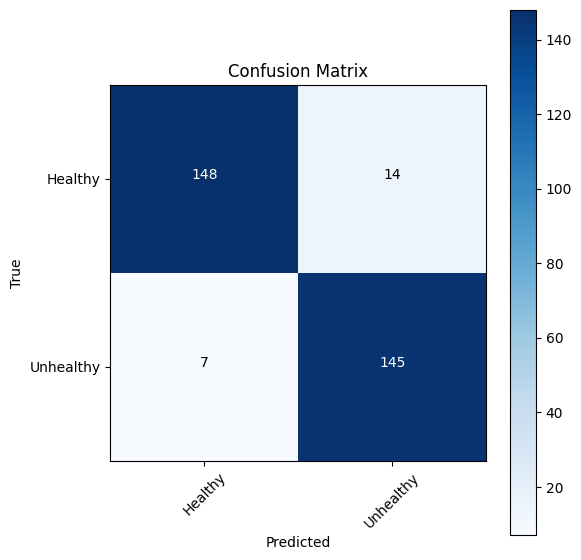


   MODEL 3: DENSENET121 SONUCLARI
IMAGE SIZE : 224x224
CONVERT    : RGB
EPOCH      : 10
LR         : 0.0001
----------------------------------------
ACCURACY   : %93.31
F1-SCORE   : 0.9331
ROC-AUC    : 0.9820

SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

     Healthy       0.95      0.91      0.93       162
   Unhealthy       0.91      0.95      0.93       152

    accuracy                           0.93       314
   macro avg       0.93      0.93      0.93       314
weighted avg       0.93      0.93      0.93       314



BASARILI! Tum dosyalar 'Rapor_Ciktilari' klasorune kaydedildi.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "ProjeVerisi"
save_dir = "Rapor_Ciktilari"
batch_size = 32
num_epochs = 10

os.makedirs(save_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

classes = train_data.classes

try:
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
except:
    model = models.densenet121(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"DenseNet121 Egitimi Basliyor... Sonuclar '{save_dir}' klasorune kaydedilecek.")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Graph')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.savefig(os.path.join(save_dir, 'Grafik1_Loss_Accuracy.png')) 
plt.show()

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)[:, 1]
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'Grafik2_Confusion_Matrix.png'))
plt.show()

acc_score = accuracy_score(all_labels, all_preds) * 100
f1_score_val = f1_score(all_labels, all_preds, average='weighted')
try:
    roc_auc = roc_auc_score(all_labels, all_probs)
except:
    roc_auc = 0.0

report_text = f"""
========================================
   MODEL 3: DENSENET121 SONUCLARI
========================================
IMAGE SIZE : 224x224
CONVERT    : RGB
EPOCH      : {num_epochs}
LR         : 0.0001
----------------------------------------
ACCURACY   : %{acc_score:.2f}
F1-SCORE   : {f1_score_val:.4f}
ROC-AUC    : {roc_auc:.4f}
========================================

SINIFLANDIRMA RAPORU:
{classification_report(all_labels, all_preds, target_names=classes, zero_division=0)}
"""

print(report_text)

with open(os.path.join(save_dir, 'Sonuc_Tablosu.txt'), "w") as f:
    f.write(report_text)

print(f"\nBASARILI! Tum dosyalar '{save_dir}' klasorune kaydedildi.")